In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from helpers import create_csv_submission
from helpers import load_csv_data
from implementations import mean_squared_error_gd, mean_squared_error_sgd, least_squares, ridge_regression, logistic_regression, reg_logistic_regression, sigmoid

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data/dataset", sub_sample=False)

<h3>Performing manual analysis</h3>

We start by looking into the data and removing data corresponding to identifiers and administrative codes and those corresponding to dates and times.
Moreover, we want to drop the features when the percentage of missing values is higher than an optimal percentage (check the references in the report and explanations).

In [ ]:
'''with open("data/dataset/x_train.csv", "r") as f:
    reader = csv.reader(f)
    headers = next(reader)               # first row = column names
    data = [row for row in reader]       # rest = data

# Convert data to NumPy (floats, NaN for missing)
x_train = np.array([[float(val) if val != "" else np.nan for val in row] for row in data])


print("Original shape:", x_train.shape)

# Columns to remove
cols_to_remove = [
    "Id", "SEQNO", "_PSU", "_STSTR", "DISPCODE", "QSTVER", "MSCODE",
    "IDATE", "IMONTH", "IDAY", "IYEAR", "FMONTH"
]

# Find indices of those columns
remove_indices = [i for i, col in enumerate(headers) if col in cols_to_remove]

# Create a copy before removing
x_train_cleaned = np.copy(x_train)
x_train_cleaned = np.delete(x_train_cleaned, remove_indices, axis=1)

# Also update headers
headers_cleaned = [col for col in headers if col not in cols_to_remove]

print("Removed columns:", [headers[i] for i in remove_indices])
print("New shape:", x_train_cleaned.shape)
'''


Now we need to look into the Data and check how many data remain if we choose a certain percentage of missing values. For that purpose we need to plot the number of remaining features according to the chosen threshold.

<h5>x-axis = thresholds (% of missingness allowed).</h5>
<h5>y-axis = number of features with at most that much missing data.</h5>
The bar plot shows how strict or lenient we can be with missingness.
<h5>Left side (low threshold): shows how many features are almost complete.</h5>
<h5>Right side (higher threshold): shows how many features remain if you allow more missing data.</h5>
<h5>We can use it to decide: “If I drop all features with more than 20% missing values, how many features will I keep?”</h5>

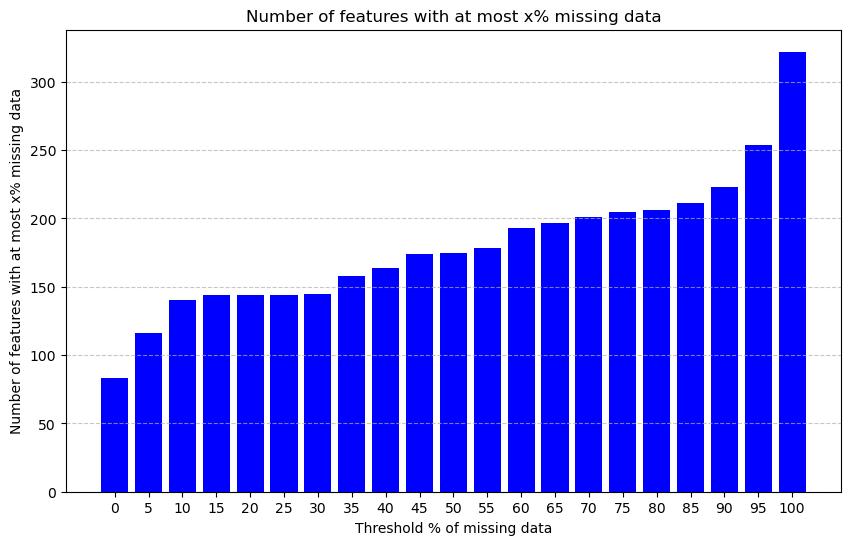

Final shape: (328135, 164)
Remaining features: 164
kept features: ['0', '53', '11', '11162015', '11', '16', '2015', '1100', '2015015629', '2015015629', '2', '1', '5', '1', '1', '2', '1', '3', '1', '1', '2', '2', '2', '2', '2', '2', '2', '1', '2', '3', '2', '1', '5', '1', '2', '1', '88', '8', '1', '110', '501', '1', '2', '2', '2', '2', '2', '2', '1', '3', '888', '555', '205', '304', '303', '308', '205', '1', '64', '102', '30', '98', '105', '1', '1', '2', '2', '20', '1', '532049', '120.93168021690366', '1.0', '120.93168021690366', '', '2', '0.2339478903073485', '264.741181241164', '1', '1', '1', '1', '1', '1', '1', '3', '2', '1', '1', '2', '1', '1', '1', '1', '8', '1', '57', '5', '61', '1.55', '49.9', '20.78', '2', '1', '1', '3', '5', '1', '2', '2', '0', '1', '0', '1', '0.0', '0.71', '0.13', '0.1', '0.27', '0.71', '0', '0', '1', '1', '0.71', '1.21', '2', '1', '1', '1', '0', '0', '1', '3.5', '4.5', '26.91', '4.61', '1', '1', '30', '2.0', '60', '140', '5.0', '0', '60', '140', '200', '0', '

In [17]:
CSV_PATH = "data/dataset/x_train.csv"

# 1) read headers
with open('data/dataset/x_train.csv', 'r') as file:
    reader = csv.reader(file)
    headers = next(reader)[1:]
    feature_names = next(reader)

# 2) load numeric data (skip header row)
X = np.genfromtxt(
    CSV_PATH,
    delimiter=",",
    skip_header=1,
    dtype=float,
    missing_values=("","7","77","777","9","99","999"),
    filling_values=np.nan
)

# 3) compute % missing
missing_pct = np.isnan(X).mean(axis=0) * 100
thresholds = np.arange(0, 101, 5)
feature_counts = [(missing_pct <= threshold).sum() for threshold in thresholds]

plt.figure(figsize=(10, 6))
plt.bar(thresholds, feature_counts, color='b', width=4)
plt.xlabel('Threshold % of missing data')
plt.ylabel('Number of features with at most x% missing data')
plt.title('Number of features with at most x% missing data')
plt.xticks(thresholds)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("plot.png", dpi=300)
plt.show()

# 4) keep features with ≤40% missing
mask40 = missing_pct <= 40
X = X[:, mask40]
feature_names = [name for i, name in enumerate(feature_names) if mask40[i]]

# 5) remove specific administrative/date/ID columns
remove_cols = ['Id', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR',
               'DISPCODE', 'SEQNO', '_PSU', 'QSTVER', 'MSCODE', '_STSTR']
remove_idx = [i for i, name in enumerate(feature_names) if name in remove_cols]

X_reduced = np.delete(X, remove_idx, axis=1)
feature_names_reduced = [name for i, name in enumerate(feature_names) if i not in remove_idx]

# 6) check results
print("Final shape:", X_reduced.shape)
print("Remaining features:", len(feature_names_reduced))
print("kept features:", feature_names_reduced)


### We have decided to keep features with missing data up to 40% after plot analysis and some article readings.

#### 1. Demographics (baseline predictors)
- `SEX`
- `AGEG5YR`, `_AGE65YR` (senior flag), `_AGE80` (80+)
- `INCOME2`, `_INCOMG`
- `MARITAL`
- `EMPLOY1`
- `RENTHOM1`
- `CHILDREN`, `_CHLDCNT`
- `_RACE`, `_PRACE1`, `_HISPANC` (broad + detailed race/ethnicity)

#### 2. General health & healthcare access
- `GENHLTH`
- `PHYSHLTH`
- `MENTHLTH`
- `HLTHPLN1` (health coverage)
- `PERSDOC2` (personal doctor)
- `MEDCOST` (cost barrier)
- `CHECKUP1` (routine checkup)

#### 3. Chronic conditions
- `BPHIGH4` (high blood pressure)
- `BLOODCHO`, `CHOLCHK`, `TOLDHI2` (cholesterol)
- `CVDSTRK3` (stroke)
- `ASTHMA3`
- `CHCSCNCR`, `CHCOCNCR` (cancers)
- `CHCCOPD1` (COPD)
- `HAVARTH3` (arthritis)
- `ADDEPEV2` (depression)
- `CHCKIDNY` (kidney disease)
- `DIABETE3` (diabetes)

#### 4. Behaviors – smoking, alcohol, diet, exercise, prevention
- **Smoking:** `SMOKE100`, `USENOW3`, `_SMOKER3`, `_RFSMOK3`
- **Alcohol:** `ALCDAY5`, `DRNKANY5`, `_RFBING5`, `_RFDRHV5`
- **Diet:** `FRUIT1`, `FVGREEN`, `FVORANG`, `VEGETAB1`, `FRUITJU1`, `FVBEANS`, `_FRUTSUM`, `_VEGESUM`, `_FRTLT1`, `_VEGLT1`
- **Physical activity:** `EXERANY2`, `_TOTINDA`, `STRENGTH`, `_PA150R2`, `_PA300R2`, `_PASTRNG`
- **Safety & prevention:** `SEATBELT`, `FLUSHOT6`, `PNEUVAC3`, `HIVTST6`

#### 5. Anthropometrics
- `WEIGHT2`, `HEIGHT3`, `WTKG3`
- `_BMI5`, `_BMI5CAT`, `_RFBMI5`

#### 6. Psychosocial / functional health
- `QLACTLM2` (activity limitation)
- `USEEQUIP` (equipment use for disability)
- `BLIND`
- `DECIDE` (cognitive difficulties)
- `DIFFWALK`, `DIFFDRES`, `DIFFALON`


In [18]:
x_train.shape
len(headers)

321

In [5]:
kept_features = [
    # 1. Demographics
    "SEX", "AGEG5YR", "_AGE65YR", "_AGE80",
    "INCOME2", "_INCOMG", "MARITAL", "EMPLOY1",
    "RENTHOM1", "CHILDREN", "_CHLDCNT",
    "_RACE", "_PRACE1", "_HISPANC",

    # 2. General health & healthcare access
    "GENHLTH", "PHYSHLTH", "MENTHLTH",
    "HLTHPLN1", "PERSDOC2", "MEDCOST", "CHECKUP1",

    # 3. Chronic conditions
    "BPHIGH4", "BLOODCHO", "CHOLCHK", "TOLDHI2",
    "CVDSTRK3", "ASTHMA3", "CHCSCNCR", "CHCOCNCR",
    "CHCCOPD1", "HAVARTH3", "ADDEPEV2",
    "CHCKIDNY", "DIABETE3",

    # 4. Behaviors – smoking, alcohol, diet, exercise, prevention
    "SMOKE100", "USENOW3", "_SMOKER3", "_RFSMOK3",
    "ALCDAY5", "DRNKANY5", "_RFBING5", "_RFDRHV5",
    "FRUIT1", "FVGREEN", "FVORANG", "VEGETAB1",
    "FRUITJU1", "FVBEANS", "_FRUTSUM", "_VEGESUM",
    "_FRTLT1", "_VEGLT1",
    "EXERANY2", "_TOTINDA", "STRENGTH",
    "_PA150R2", "_PA300R2", "_PASTRNG",
    "SEATBELT", "FLUSHOT6", "PNEUVAC3", "HIVTST6",

    # 5. Anthropometrics
    "WEIGHT2", "HEIGHT3", "WTKG3",
    "_BMI5", "_BMI5CAT", "_RFBMI5",

    # 6. Psychosocial / functional health
    "QLACTLM2", "USEEQUIP", "BLIND",
    "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON"
]
count = len(kept_features)
print("Number of features kept:", count)


Number of features kept: 75


<h3>Now we perform first data preprocessing</h3>

In [24]:
x = [i in kept_features for i in headers] #headers filtering

new_headers = [] # to maintain the order
for i in headers:
    if i in kept_features:
        new_headers.append(i) #makes a list of only the kept features, preserve the original order

mapping = {new_headers[i]:i for i in range(len(new_headers))} # Builds a dictionary linking each feature name to its column index in the reduced dataset, for preprocessing

In [22]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("mask length (x):", len(new_headers))

x_train shape: (328135, 321)
x_test shape: (109379, 321)
mask length (x): 74


In [25]:
#reduction of number of columns from 321 to 75
x_train_filtered = x_train[:,x] #keeps only the columns where the mask is True.
x_test_filtered = x_test[:,x]  #Ensures both train and test are filtered in the exact same way.
x_list = [x_train_filtered, x_test_filtered] #for the purpose of preprocessing the 2 sets in the same way